In [234]:
import sys
#!{sys.executable} -m pip install scikit-beam
#!{sys.executable} -m pip install numba
#!{sys.executable} -m pip install pandas

import functions # angular integration functions etc
import xpcs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from scipy.optimize import curve_fit as fit
from scipy import signal
from scipy.fftpack import fft2, fftshift

#!{sys.executable} -m pip install lmfit
#!{sys.executable} -m pip install jscatter
from jscatter.formel import schulzDistribution
from jscatter.formel import pDA
from jscatter.formfactor import sphere

from dls_data_extraction import*
from integrators import *

import time
date = time.strftime("%Y-%m-%d")
datadir = './tmp/'+date+'/' # define path for saving data

In [235]:
# experimental parameters
downsample=1
distance = 4.0 # m
photon_energy = 10.0e3 # eV
h = 4.135667696e-15 # eV*s
c = 2.99792458e8 # m/s
wavelength = h*c / photon_energy # m
pix = 55e-6 # m
center_x, center_y = 1069.5//downsample, 201.5//downsample
center = center_y, center_x 

# Sample - NP in water

In [237]:
sample = '100NP_water'
scans = 252
exp_time = 1
downsample = 1
center_x, center_y = 1069.5, 201.5 # original
rois = [(0//downsample, 250//downsample)] # single ring 1x1 binning

roi_img = xpcs.make_roi(center_x, center_y, rois, downsample)
frames = xpcs.make_frames('/data/visitors/nanomax/20210623/2021052608/raw/sample/tristan-%04d*' %scans, 
                     exp_time, roi_img, downsample)
img = xpcs.make_img(frames[0])/exp_time # ph/s  
print('done')

done


## Q-map

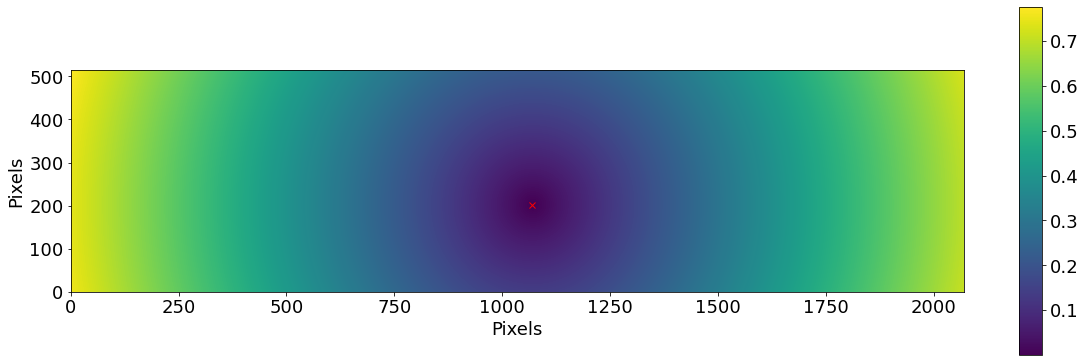

In [238]:
# make grid
x = np.arange(0,img.shape[1])
y = np.arange(0,img.shape[0])
xx,yy = np.meshgrid(x,y)
r = (((xx-center_x)**2 + (yy-center_y)**2 ) ** 0.5)
rs = r*pix
tth = np.arctan2(rs, distance)
Q = 4.0e-9 * np.pi / wavelength * np.sin(0.5*tth) # 1/nm

# Q-map
plt.figure(figsize=(20,8))
plt.imshow(Q, origin='lower') # 
plt.plot(center_x,center_y,'rx')
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])
plt.show()

# Experimental data

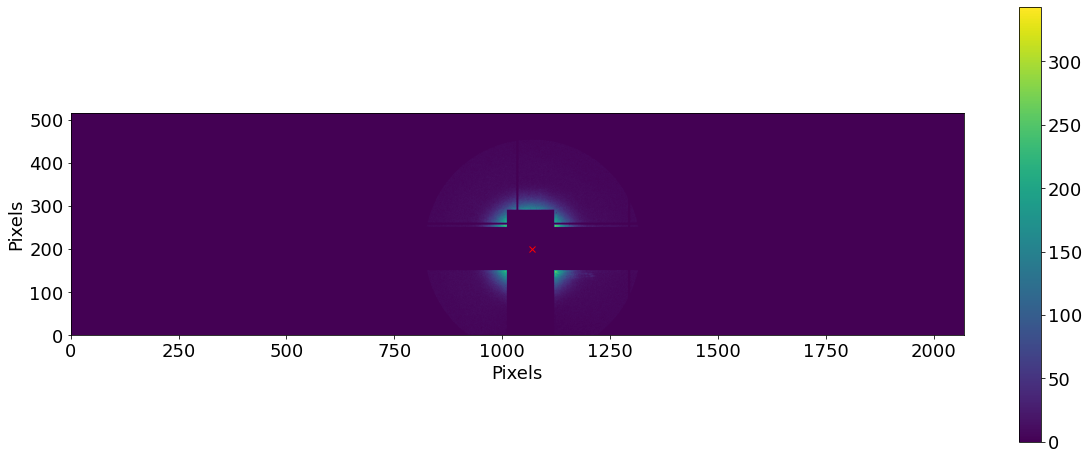

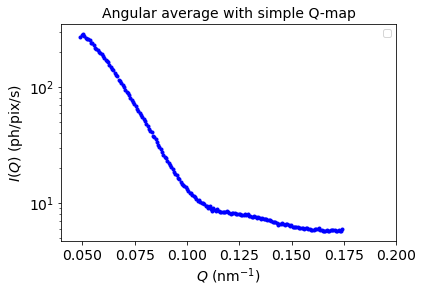

In [239]:
plt.figure(figsize=(20,8))
plt.imshow(img, origin='lower')
plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])

Q_av, I_exp = functions.calc_Iq(Q, img, roi_img, downsample, nbins=200, n_max=250, n_min=center_y, threshold=0) # experimental

plt.figure()
plt.plot(Q_av[1:],I_exp[1:],'b.')
plt.ylabel(r'$I(Q)$ (ph/pix/s)', size=14)
plt.xlabel(r'$Q$ $\rm(nm^{-1})$', size=14)
plt.title('Angular average with simple Q-map',size=14)
plt.legend()
plt.tick_params(labelsize=14)
plt.xlim([0.04,0.2])
plt.yscale('log')

plt.show()

# Model beam

beam size at detector: 4.8 mm
[0.65823529 0.65823529]


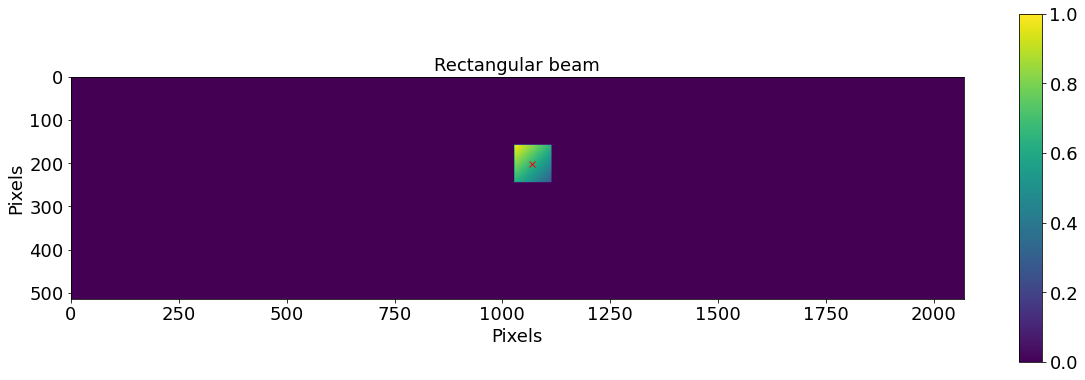

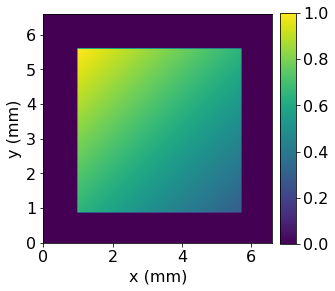

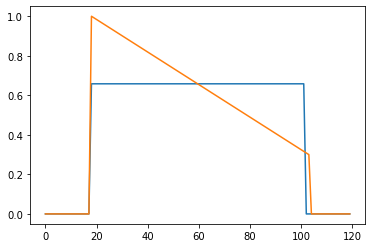

In [240]:
# beam divergence
divergence = 1.2e-3 # divergence, rad
s1 = 88e-9 # focus size, m
s2 = np.tan(divergence/2) * 2 * distance + s1 # beam size (fwhm) on detector, m
print('beam size at detector:',np.round(s2*1e3,1),'mm')

# realistic beam profile
N = s2/pix
M1,M2 = 515, 2069
ii, jj = np.indices((M1,M2))
rect_beam = ((N-ii) + (N-jj)).astype(float)
inside = (np.abs(ii-center_y) < N//2) & (np.abs(jj-center_x) < N//2)
rect_beam[~inside] = 0
rect_beam[inside] -= rect_beam[inside].min() 
rect_beam[inside] *= .7/rect_beam[inside].max() 
rect_beam[inside] += 0.3

plt.figure(figsize=(20,8))
plt.imshow(rect_beam) # 
plt.plot(center_x,center_y,'rx')
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
cbar.ax.tick_params(labelsize=18)
plt.title('Rectangular beam', size=18)

smallx1 = np.int((center_x-60)/downsample)
smallx2 = np.int((center_x+60)/downsample)
smally1 = np.int((center_y-60)/downsample)
smally2 = np.int((center_y+60)/downsample)
small_beam = rect_beam[smally1:smally2,smallx1:smallx2]
plt.figure(figsize=(5,5))
plt.imshow(small_beam, extent=[0, pix*120*1e3, 0, pix*120*1e3]) # 
plt.xlabel('x (mm)', size=16)
plt.ylabel('y (mm)', size=16)
plt.tick_params(labelsize=16)
cbar = plt.colorbar(**dict(pad=0.03, shrink=0.85, aspect=15))
cbar.ax.tick_params(labelsize=16)
plt.savefig('beam.png', dpi=300, bbox_inches='tight',) # save plot

rect_beam = rect_beam/np.sum(rect_beam) # normalize

plt.figure()
diag_beam = np.flipud(small_beam).diagonal()
diag_beam2 = small_beam.diagonal()
plt.plot(diag_beam)
plt.plot(diag_beam2)

print(diag_beam[diag_beam!=0][[0,-1]])

### real beam

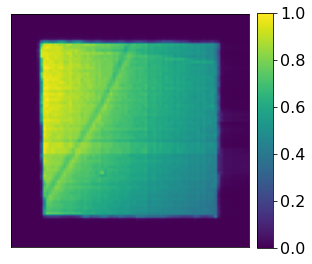

2.65900858


In [241]:
realbeam = np.load('empty_beam_3.51m_12.4keV.npz')
print(realbeam)

fig, ax = plt.subplots(figsize=(5.2,5.2))
plt.imshow(realbeam['arr_0'][760:840,1365:1447]/realbeam['arr_0'][760:840,1365:1447].max())
cbar = plt.colorbar(**dict(pad=0.03, shrink=0.83, aspect=15))
cbar.ax.tick_params(labelsize=16)
plt.tick_params(color='none')
ax.set_xticklabels('')
ax.set_yticklabels('')
plt.clim([0,1])
plt.savefig('realbeam', dpi=300, bbox_inches='tight')
plt.show()

print(realbeam['arr_0'][760:840,1365:1447].max()/1e8)

# Model form factor and convolution

In [242]:
def model_form_factor(R, sigma):
    ff = np.empty((y[-1]+1,x[-1]+1))
    for i in range(0,y[-1]):
        ff[i,:] = pDA(sphere, R*sigma, 'radius', type='Schulz', q=Q[i,:], radius=R).Y # 1D intensity based on the particle form factor
        #sp = sphere(Q[i,:], R) # without size distribution
        #ff[i,:] = sp.Y
    ff_norm = ff/np.sum(ff) # normalize it
    return ff_norm

def convolve_with_beam(img, beam):
    img_conv = signal.convolve(img, beam, mode='same')/np.sum(beam) 
    m = np.where(img_conv == img_conv.max()) # find the new center (i.e. the maximum)
    img_conv_shift = functions.shift_image(img_conv, np.int(center_x-m[1][0]),np.int(center_y-m[0][0])) # re-center image to the beam center
    return img_conv_shift, m

## fit model form factor to experimental SAXS intensity

### load saved fit parameters for model form factor

In [243]:
amplitude = np.load('Iq_fit_model_amplitude.npy')
background = np.load('Iq_fit_model_background.npy')
R = np.load('Iq_fit_model_R.npy')
sigma = np.load('Iq_fit_model_sigma.npy')

print('R (nm):', R)
print('sigma (%):', sigma*100)
print('amplitude:', amplitude, 'background:', background)

R (nm): 48.333594583447606
sigma (%): 8.441281501241866
amplitude: 12116087.634287596 background: 4.426309812407543


# Convoluted model intensity

In [244]:
#sigma=0 # without size distribution
I0 = model_form_factor(R,sigma) # model intensity without convolution
I, m = convolve_with_beam(I0,rect_beam) # model intensity with convolution

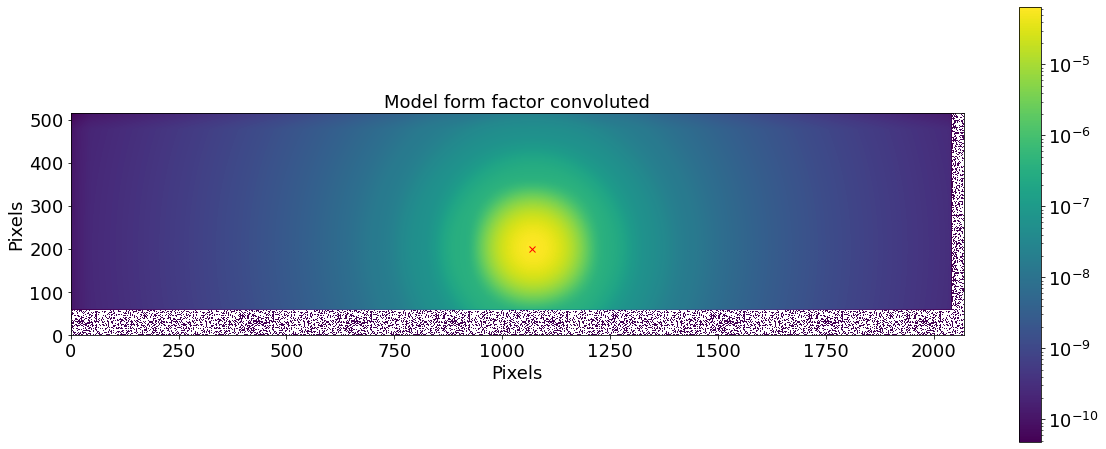

In [245]:
smallx1 = np.int((center_x-250)/downsample)
smallx2 = np.int((center_x+250)/downsample)
smally1 = np.int((center_y-140)/downsample)
smally2 = np.int((center_y+250)/downsample)

plt.figure(figsize=(20,8))
plt.imshow(I, origin='lower', norm=matplotlib.colors.LogNorm()) 
plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])
plt.title('Model form factor convoluted', size=18)

plt.show()

# Angular integration

/mxn/visitors/sharonb/jupyter_notebooks/functions.py:50: RuntimeWarning: Mean of empty slice.
  Q_av = np.array([Q_map_flat[inds == i].mean() for i in range(0, nbins+1)])
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mxn/visitors/sharonb/jupyter_notebooks/functions.py:51: RuntimeWarning: Mean of empty slice.
  I_av = np.array([I_map_flat[inds == i].mean() for i in range(0, nbins+1)])


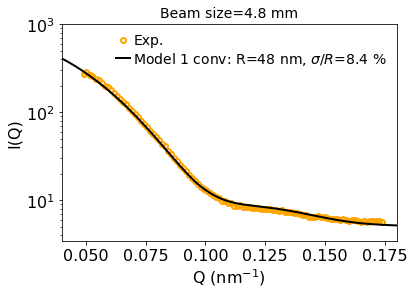

In [246]:
from lmfit.models import Model
def normalize(x, amplitude, background): 
    return np.log10(amplitude * x + background)
model = Model(normalize) 
pars = model.make_params()
pars['amplitude'].set(1e3, min=0)
pars['background'].set(4, min=0, max=100)

# model without convolution
Q_av_m, I_model0 = functions.calc_Iq(Q, I0, None, downsample, nbins=200, n_max=250, n_min=140, threshold=0) # model without convolution
scale_model0 = model.fit(np.log10(I_exp[1:]), params=pars, x=I_model0[1:]) # fit amplitude and background to experimental data

# model with convolution
Q_av_m, I_model = functions.calc_Iq(Q, I, None, downsample, nbins=400, n_max=400, n_min=140, threshold=0) # convoluted model, larger Q-range
Q_av_m, I_model0 = functions.calc_Iq(Q, I0, None, downsample, nbins=400, n_max=400, n_min=140, threshold=0) # model without convolution

# experiment
Q_av, I_exp = functions.calc_Iq(Q, img, roi_img, downsample, nbins=200, n_max=250, n_min=center_y, threshold=0) # experimental

###############################################################
# fitted amplitude and background to match the experimental data:
###############################################################

# plot I(q) with convolution:
plt.figure()
plt.plot(Q_av[1::2],I_exp[1::2],'o', ms=5, markeredgecolor='orange', markerfacecolor='none', markeredgewidth=2, label='Exp.')
plt.plot(Q_av_m[1:], I_model[1:]*amplitude + background,'k-', lw=2, label='Model 1 conv: R=%.d nm, $\sigma/R$=%.1f %%' %(R, sigma*100))

plt.xlabel('Q (nm$^{-1}$)',size=16)
plt.ylabel('I(Q)',size=16)
plt.yscale('log')
plt.title('Beam size=%.1f mm' %(s2*1e3),size=14)
plt.tick_params(labelsize=16)
plt.legend(loc='upper right', frameon=False, prop={'size': 14}, labelspacing=0.2, handletextpad=0.2, handlelength=1.0, borderpad=0.2)
plt.xlim([0.04,0.18])

#plt.savefig('Iq_conv_'+str(scans)+'.png', dpi=300, bbox_inches='tight',) # save plot

plt.show()

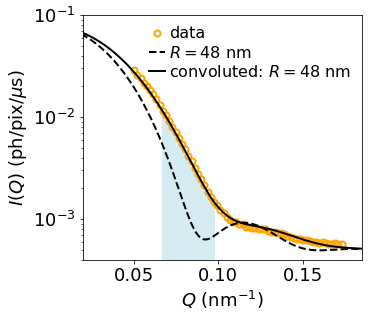

In [247]:
# plot I(q) for paper

unit = 1e6 
binning = 10*10


# display the results
fig = plt.figure(figsize=[5,4.5])

plt.plot(Q_av[::3], I_exp[::3]/exp_time/unit*binning, 'o', ms=6, markeredgecolor='orange', markerfacecolor='none', markeredgewidth=2, label='data')
plt.plot(Q_av_m[1:],(I_model0[1:]*amplitude*0.75  + background)/unit*binning, 'k--', lw=2, label=r'$R = %.d$ nm' %(R))
plt.plot(Q_av_m[1:],(I_model[1:]*amplitude + background)/unit*binning, 'k-', lw=2, label=r'convoluted: $R = %.d$ nm' %(R))

indlim=np.argwhere((Q_av>0.0664) & (Q_av<0.099))
plt.fill_between(Q_av[indlim[0][0]:indlim[-1][0]], I_exp[indlim[0][0]:indlim[-1][0]]/exp_time/unit*binning, facecolor='lightblue', alpha=0.5)

plt.ylabel('$I(Q)$ (ph/pix/$\mu$s)',size=18) # per 10x10 superpixel
plt.xlabel('$Q$ (nm$^{-1}$)',size=18)
plt.tick_params(labelsize=18)
plt.legend(loc='upper right', frameon=False, prop={'size': 16}, labelspacing=0.2, handletextpad=0.2, handlelength=1.0, borderpad=0.2);
plt.yscale('log')
plt.xlim([2e-2,18.5e-2])
plt.ylim([4e-4, 10e-2]) 

plt.savefig('Iq_'+sample+'_'+str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight',) # save plot

plt.show()

In [301]:
def make_decay_rate_map(Rh):
    # load viscosities:
    ndata_w1 = np.loadtxt('./viscositydata_dehaoui.dat', delimiter=',') # mPas, water viscosity from dehaoui et al.
    ndata_w2 = np.loadtxt('./macroscopic_viscosity_water_hallet_kestin_collings.dat', delimiter=',') # mPas, macroscopic water viscosity 
    ndata_w = np.vstack((ndata_w1,ndata_w2))
    n_dmso = np.array([339.6, 214.7, 140.2, 43.47, 18.25, 14.27, 9.16, 6.17, 5.18, 4.383])*1e-3 # Pas, 33 mol% dmso
    T_dmso = np.array([-55, -50, -45, -30, -15, -10, 0, 10, 15, 20])+273.15; # K 
    popt_w,pcov_w = fit(power_law,ndata_w[:,0],ndata_w[:,1]*1e-3,p0=[1e-4, 220, 2]) # Pas, power law fit water
    popt_dmso_power,pcov_dmso_power = fit(power_law,T_dmso[6:],n_dmso[6:],p0=[1e-4, 200, 3]) # Pas, power law fit dmso-water
    if solvent == 'water':
        viscosity = power_law(T,*popt_w)
    elif solvent == 'dmso':
        viscosity = power_law(T,*popt_dmso_power)
    # calculate the decay rate map:
    k = 1.38064852e-23
    D = k*T/(6*np.pi*Rh*1e-9*viscosity)  # SE diffusion coefficient
    return D #*(Q*1e9)**2 # map of decay rates


from scipy.interpolate import interp1d
def model_func_xpcs_fit(x, Rh): 
    #Gamma0 = make_decay_rate_map(Rh)
    D = make_decay_rate_map(Rh)
    #X_conv = signal.convolve(Gamma0*I0, rect_beam, mode='same')/np.sum(rect_beam)  # convolute the Gamma0*I0
    X_conv = signal.convolve(Q*I0, rect_beam, mode='same')/np.sum(rect_beam)
    #Gamma = functions.shift_image(X_conv, np.int(center_x-m[1][0]),np.int(center_y-m[0][0]))/I # shift and divide by conv convolved model I0 
    Qconv = functions.shift_image(X_conv, np.int(center_x-m[1][0]), np.int(center_y-m[0][0]))/I
    #Q_av, Gamma_av = functions.calc_Iq(Q, Gamma, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0) # n_min=140 due to shift, to avoid the lower zero rows
    Q_av, Qconv_av = functions.calc_Iq(Q, Qconv, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0)
    #tau_interp = interp1d(Q_av[1:], 1/Gamma_av[1:]*1e6, kind='cubic')
    Qconv_av = Qconv_av*1e9 # 1/nm to 1/m
    tau_interp = interp1d(Q_av[1:], 1/(D*Qconv_av[1:]**2)*1e6, kind='cubic')
    return tau_interp(x)

## Fit relaxation times

In [343]:
solvent = 'water'
T = 295 # K

ndata_w1 = np.loadtxt('./viscositydata_dehaoui.dat', delimiter=',')
ndata_w2=np.loadtxt('./macroscopic_viscosity_water_hallet_kestin_collings.dat',delimiter=',')
ndata_w=np.vstack((ndata_w1,ndata_w2))
n_dmso = np.array([339.6, 214.7, 140.2, 43.47, 18.25, 14.27, 9.16, 6.17, 5.18, 4.383])*1e-3 # schichman & Amey, JPC 1971
T_dmso = np.array([-55, -50, -45, -30, -15, -10, 0, 10, 15, 20])+273.15
popt_w, pcov_w= fit(power_law,ndata_w[:,0],ndata_w[:,1]*1e-3,p0=[1e-4,220,2])
popt_dmso_power, pcov_dmso_power = fit(power_law,T_dmso[6:],n_dmso[6:], p0=[1e-4,200,3])

if solvent=='water':
    tau_data_exp = np.load('tau_data_water.npy')
    Rh_all, Rh_err_all = fit(model_func_xpcs_fit, tau_data_exp[0,:], tau_data_exp[1,:], sigma=tau_data_exp[2,:], p0=[50])
    print(Rh_all, Rh_err_all)
    viscosity=power_law(T,*popt_w)
elif solvent=='dmso':
    tau_data_exp = np.load('tau_data_dmso.npy')
    Rh_all = np.empty((3,))
    Rh_err_all = np.empty((3,))
    for i in range(3):
        Rh_all[i], Rh_err_all[i] = fit(model_func_xpcs_fit, tau_data_exp[0,:,i], tau_data_exp[1,:,i], sigma=tau_data_exp[2,:,i], p0=[60])
    print(Rh_all, Rh_err_all)
    viscosity = power_law(T, *popt_dmso_power)

k=1.38064852e-23
D = k*T/(6*np.pi*Rh_all*1e-9*viscosity)
Derr = k*T/(6*np.pi*viscosity)*1/(Rh_all*1e-9)**2*Rh_err_all*1e-9
print(D, Derr)

<ipython-input-301-d9f51e3ba184>:27: RuntimeWarning: invalid value encountered in true_divide
  Qconv = functions.shift_image(X_conv, np.int(center_x-m[1][0]), np.int(center_y-m[0][0]))/I


[79.32322154] [[0.71359765]]
[2.84642878e-12] [[2.56066868e-14]]


## map of decay rates

In [340]:
i = 0
save = True
Rh = Rh_all[i]
print(Rh)
#Gamma0 = make_decay_rate_map(Rh)
D = make_decay_rate_map(Rh)

78.51508540924081


<ipython-input-341-f387d97629ec>:34: RuntimeWarning: invalid value encountered in true_divide
  Qconv = functions.shift_image(X_conv, np.int(center_x-m[1][0]), np.int(center_y-m[0][0]))/I


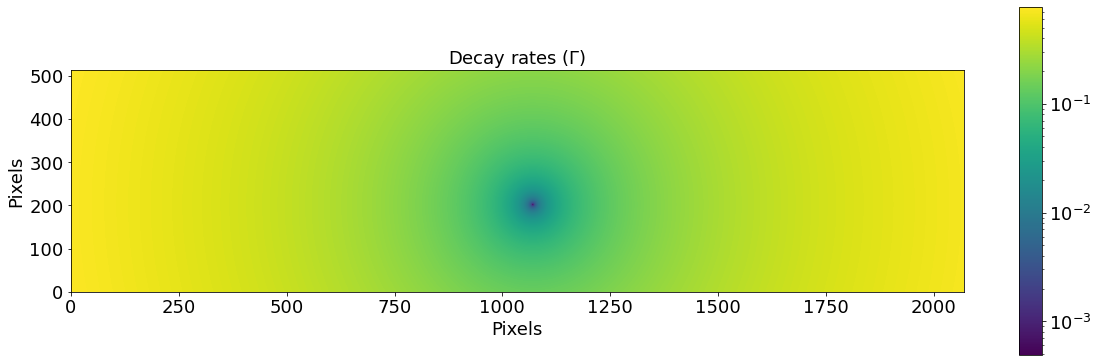

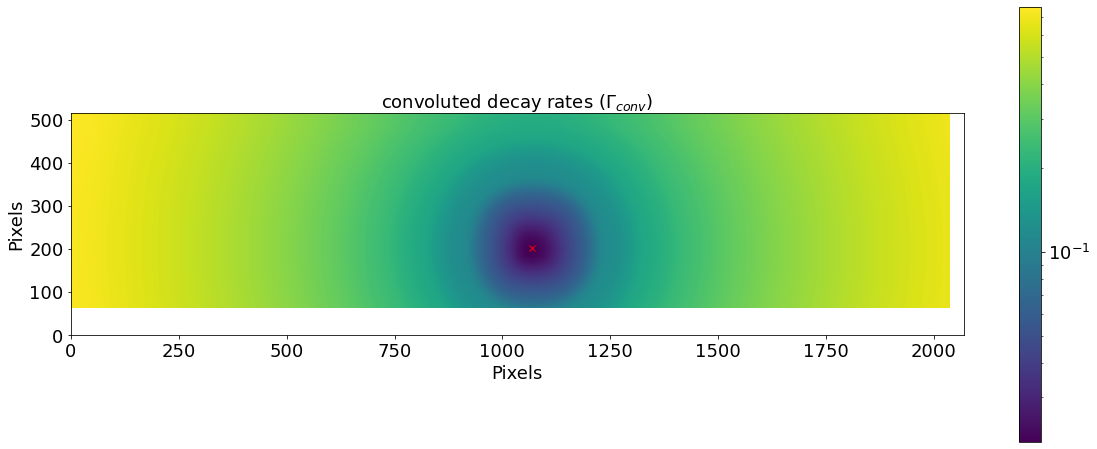

In [341]:
plt.figure(figsize=(20,8))
plt.imshow(Q, origin='lower', norm=matplotlib.colors.LogNorm()) # 
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
cbar.ax.tick_params(labelsize=18)
plt.title(r'Decay rates ($\Gamma$)', size=18)

#plt.figure(figsize=(20,8))
#plt.imshow(Gamma0*I0, origin='lower', norm=matplotlib.colors.LogNorm()) # 
#plt.xlabel('Pixels', size=18)
#plt.ylabel('Pixels', size=18)
#plt.tick_params(labelsize=18)
#cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
#cbar.ax.tick_params(labelsize=18)
#plt.title(r'Decay rates ($\Gamma$) weighted', size=18)

# convolve with the model beam: 
#X_conv = signal.convolve(Gamma0*I0, rect_beam, mode='same')/np.sum(rect_beam)  # convolute the Gamma0*I0
X_conv = signal.convolve(Q*I0, rect_beam, mode='same')/np.sum(rect_beam)

#plt.figure(figsize=(20,8))
#plt.imshow(X_conv, origin='lower') 
#plt.plot(center_x,center_y,'rx')
#cbar = plt.colorbar()
#plt.xlabel('Pixels', size=18)
#plt.ylabel('Pixels', size=18)
#plt.tick_params(labelsize=18)
#cbar.ax.tick_params(labelsize=18)
#plt.title(r'convolution, before shift', size=18) 

#Gamma = functions.shift_image(X_conv, np.int(center_x-m[1][0]),np.int(center_y-m[0][0]))/I # shift and divide by conv convolved model I0 (i.e. I) to retrieve the convolved intensity-weighted Gamma
Qconv = functions.shift_image(X_conv, np.int(center_x-m[1][0]), np.int(center_y-m[0][0]))/I

plt.figure(figsize=(20,8))
plt.imshow(Qconv, origin='lower', norm=matplotlib.colors.LogNorm()) 
plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.title(r'convoluted decay rates ($\Gamma_{conv}$)', size=18) 

plt.show()

## angular integration of the convolved decay rate map

[[6.42780862e-02 6.68874527e-02 7.11154105e-02 7.45149873e-02
  7.85120394e-02 8.11353356e-02 8.47516837e-02]
 [7.27734332e+02 5.84874880e+02 5.77895391e+02 4.86384039e+02
  4.17365442e+02 3.89468269e+02 3.23223791e+02]
 [5.47357052e+01 4.11275566e+01 6.03447814e+01 5.30857693e+01
  6.47137075e+01 8.15082554e+01 6.26891436e+01]]
fitted Q-exponents:
normal: 1.9999876420587035 conv: 2.569365658279028
fitted D:
normal: 2.6990676121644377e-12
conv: 1.603574670000558e-12
0.0643069735224743 0.09873491252558537


<ipython-input-342-9a3c7ae2a1b8>:61: RuntimeWarning: divide by zero encountered in true_divide
  np.save('tau_av_NPdmso_'+str(i),1/Gamma_av)
<ipython-input-342-9a3c7ae2a1b8>:62: RuntimeWarning: divide by zero encountered in true_divide
  np.save('tau0_av_NPdmso_'+str(i),1/Gamma0_av)


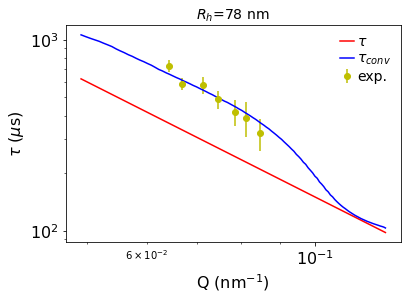

In [342]:
#Q_av, Gamma0_av = functions.calc_Iq(Q, Gamma0, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0) # n_min=140 due to shift, to avoid the lower zero rows
#Q_av, Gamma_av = functions.calc_Iq(Q, Gamma, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0) # n_min=140 due to shift, to avoid the lower zero rows

Q_av, Qconv_av = functions.calc_Iq(Q, Qconv, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0)
Gamma_av = D*(Qconv_av*1e9)**2
Gamma0_av = D*(Q_av*1e9)**2
ind = np.argwhere((Q_av>0.06427809) & (Q_av<0.09889776)) # fit similar Q-range as the experimental data

# Q-exponent fit:
#def tau_fit(x,a,b):
 #   return -a*x + b # q-dependence fit
#popt, pcov = fit(tau_fit, np.log(Q_av[1:]), np.log(1/Gamma0_av[1:]), p0=[2,1]) 
#popt_c, pcov_c = fit(tau_fit, np.log(Q_av[ind[0][0]-1:ind[-1][0]+1]), np.log(1/Gamma_av[ind[0][0]-1:ind[-1][0]+1]), p0=[2,1]) 

# Q^2 fit:
#def tau_fit2(x,a):
#    return (1/a)*x  
#popt2, pcov2 = fit(tau_fit2, 1/(Q_av[1:]*1e9)**2, 1/Gamma0_av[1:], p0=[1e-12]) 
#popt_c2, pcov_c2 = fit(tau_fit2, 1/(Q_av[ind[0][0]:ind[-1][0]]*1e9)**2, 1/Gamma_av[ind[0][0]:ind[-1][0]], p0=[1e-12])

if solvent=='water':
    tau_data_exp = np.load('tau_data_water.npy')
elif solvent=='dmso':
    tau_data_exp = np.load('tau_data_dmso.npy')
    tau_data_exp = tau_data_exp[:,:,i]
print(tau_data_exp)

from scipy.interpolate import interp1d
tau_interp = interp1d(Q_av[1:], 1/Gamma_av[1:]*1e6, kind='cubic')
qvals = np.linspace(Q_av[1], Q_av[-1], 100)

# plot angular average, log Q scale
plt.figure()
plt.plot(Q_av[1:],1/Gamma0_av[1:]*1e6,'r-', label=r'$\tau$')
plt.plot(Q_av[1:],1/Gamma_av[1:]*1e6,'b-', label=r'$\tau_{conv}$')
#plt.plot(Q_av[1:], np.exp(tau_fit(np.log(Q_av[1:]), *popt))*1e6,'g-', lw=1.5, label=r'$Q^n$-fit') 
#plt.plot(Q_av[1:], np.exp(tau_fit(np.log(Q_av[1:]), *popt_c))*1e6,'m-', lw=1.5, label=r'$Q^n$-fit') 
plt.errorbar(tau_data_exp[0,:], tau_data_exp[1,:], yerr=tau_data_exp[2,:], fmt='o', color='y', label='exp.')
plt.xlabel(r'Q (nm$^{-1}$)', size=16)
plt.ylabel(r'$\tau$ ($\mu$s)', size=16)
plt.yscale('log')
plt.xscale('log')
plt.title('$R_h$=%.d nm' %(Rh),size=14)
plt.tick_params(labelsize=16)
plt.legend(loc='best', frameon=False, prop={'size': 14}, labelspacing=0.2, handletextpad=0.2, handlelength=1.0, borderpad=0.2);

print('fitted Q-exponents:')
print('normal:',popt[0],'conv:', popt_c[0])
print('fitted D:')
print('normal:', popt2[0])
print('conv:', popt_c2[0])
print(Q_av[ind[0][0]], Q_av[ind[-1][0]])

if save == True:
    if solvent=='water':
        np.save('Q_av_tau_NPwater',Q_av)
        np.save('tau_av_NPwater',1/Gamma_av)
        np.save('tau0_av_NPwater',1/Gamma0_av)
    elif solvent=='dmso':
        np.save('Q_av_tau_NPdmso_'+str(i),Q_av)
        np.save('tau_av_NPdmso_'+str(i),1/Gamma_av)
        np.save('tau0_av_NPdmso_'+str(i),1/Gamma0_av)

# Convolve Q-map with model beam

[2.6990412e-12]
0.037666831450217014 0.12071430311332884 0.04911938817445969 0.12406470848292336


<ipython-input-293-9cef153f697e>:10: RuntimeWarning: invalid value encountered in true_divide
  Q_conv_shift = functions.shift_image(Q_conv, np.int(center_x-m[1][0]),np.int(center_y-m[0][0]))/I # re-center image to the beam center
/mxn/visitors/sharonb/jupyter_notebooks/functions.py:50: RuntimeWarning: Mean of empty slice.
  Q_av = np.array([Q_map_flat[inds == i].mean() for i in range(0, nbins+1)])
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mxn/visitors/sharonb/jupyter_notebooks/functions.py:51: RuntimeWarning: Mean of empty slice.
  I_av = np.array([I_map_flat[inds == i].mean() for i in range(0, nbins+1)])


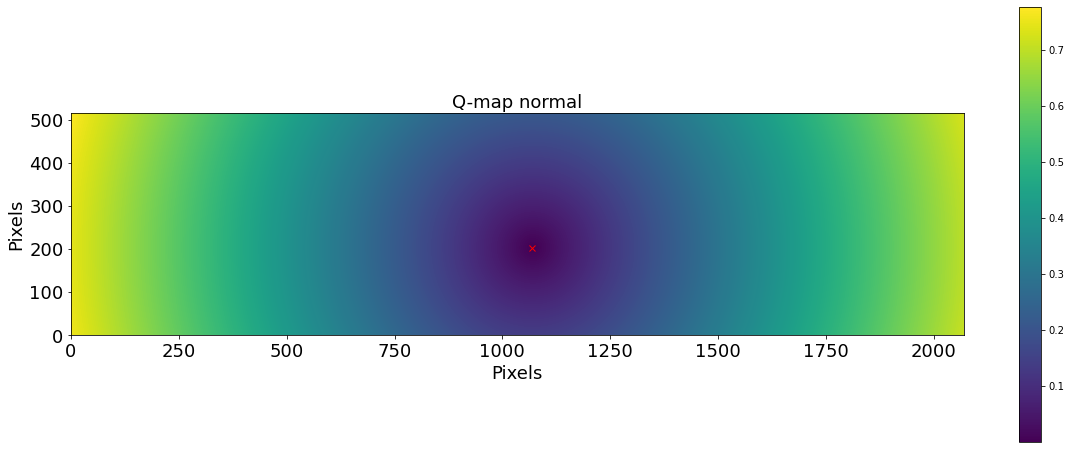

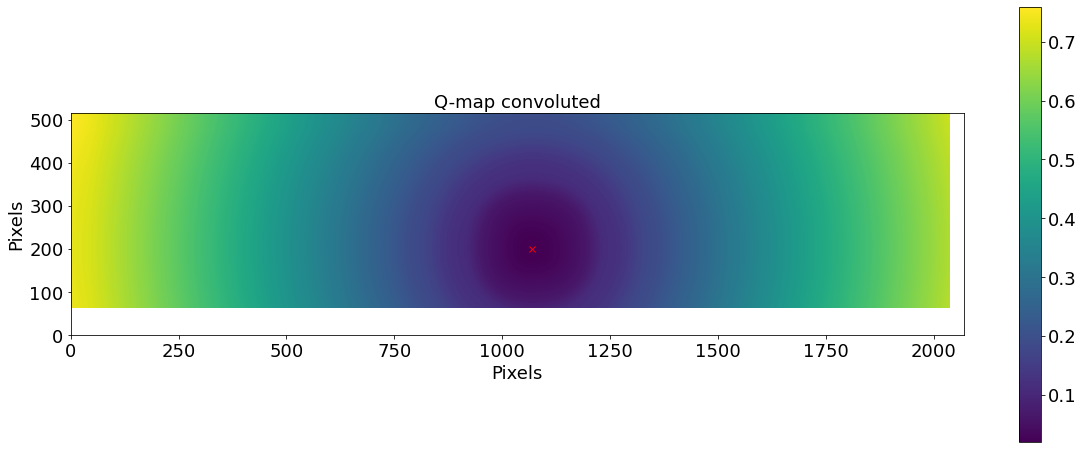

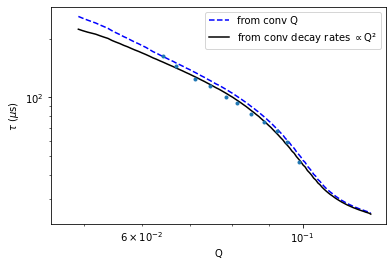

In [293]:
# convolve Q-map with model beam image 
print(D)

smallx1 = np.int((center_x-250)/downsample)
smallx2 = np.int((center_x+250)/downsample)
smally1 = np.int((center_y-140)/downsample)
smally2 = np.int((center_y+250)/downsample)

Q_conv = signal.convolve(Q*I0, rect_beam, mode='same')/np.sum(rect_beam) # intensity-weighted convolution
Q_conv_shift = functions.shift_image(Q_conv, np.int(center_x-m[1][0]),np.int(center_y-m[0][0]))/I # re-center image to the beam center
#Q_conv_shift = np.sqrt(Q_conv_shift)

plt.figure(figsize=(20,8))
plt.imshow(Q, origin='lower') 
plt.plot(center_x,center_y,'rx')
plt.title('Q-map normal', size=18)
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
plt.colorbar()

plt.figure(figsize=(20,8))
plt.imshow(Q_conv_shift, origin='lower') 
plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])
plt.title('Q-map convoluted', size=18)

############################################

Q_old, Q_new = functions.calc_Iq(Q, Q_conv_shift, None, downsample, nbins=200, n_max=200, n_min=140, threshold=-1) # calc Q 1d using the Q-bins from the normal Q-map

plt.figure()
#plt.plot(D*Q_old[1:]**2*1e18,'r', label='normal')
#plt.plot(D*Q_new[1:]**2*1e18,'b', label='convoluted')

Q_old, Q_new = functions.calc_Iq(Q, Q_conv_shift, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0) # calc Q 1d using the Q-bins from the normal Q-map

#plt.plot(Q_old[1:], 1/(D*Q_old[1:]**2*1e18)*1e6,'r--', label='no conv')
plt.plot(Q_old[1:], 1/(D*Q_new[1:]**2*1e18)*1e6,'b--', label='from conv Q')
plt.plot(Q_av[1:], 1/Gamma_av[1:]*1e6,'k',label=r'from conv decay rates $\propto$Q²')
#plt.plot(Q_av[1:], 1/Gamma0_av[1:]*1e6,'k', label='decay rate masked')
plt.plot(tau_data_exp[0,:], tau_data_exp[1,:], '.', 'exp.')
print(Q_new[1], Q_new[-1], Q_old[1], Q_old[-1] )

plt.xlabel('Q')
plt.ylabel(r'$\tau$ ($\mu$s)')
plt.xlim([0.045,0.13])
#plt.ylim([0,40000])
plt.xscale('log')
plt.yscale('log')
plt.legend()

# Intensity-weighted radius

DLS Q-range: 48.980390267104106
Nanomax convoluted Q-range: 46.450203293145776


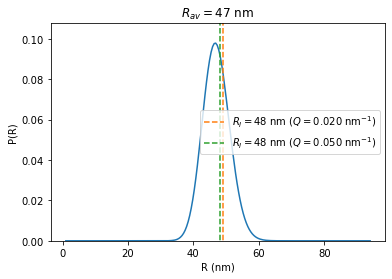

In [111]:
import jscatter as js
import scipy.integrate as integrate

radius = 48 # nm, mean radius of the size distribution
sigma = 0.08*radius 

def nom(r,q,R=radius): # nominator for intensity-weighted averaging
    SZ = js.formel.schulzDistribution(r, R, sigma) # relative number of particles with radius r
    sp = js.ff.sphere(q, r) # form factor scattering intensity
    nom = (r * SZ.Y * sp.Y) 
    return nom

def den(r,q,R=radius): # denominator for intensity-weighted averaging
    SZ = js.formel.schulzDistribution(r, R, sigma)
    sp = js.ff.sphere(q, r)
    den = (SZ.Y * sp.Y) 
    return den

def f(q):
    r1, r2 = 1.0, 200.0
    y_nom, err_nom = integrate.quad(nom, r1, r2, args=(q,))
    y_den, err_den = integrate.quad(den, r1, r2, args=(q,))
    return y_nom/y_den # intensity-weighted average R for q=q


#############################
# integrate over q-range:
a, b = 0.0177, 0.0238 # DLS q-range
y, err = integrate.quad(f, a, b)
print('DLS Q-range:',y/(b-a))

a, b = 0.064, 0.1 # nanomax convoluted q-range
y, err = integrate.quad(f, a, b)
print('Nanomax convoluted Q-range:',y/(b-a))
#############################


plt.figure()
R=radius # nm
q = np.array([0.02, 0.05]) # nm-1
r = np.linspace(1,R*2,200)
SZ = js.formel.schulzDistribution(r, R, sigma)
plt.plot(SZ.X, SZ.Y,'-')

for i in range(len(q)):
    R_int = f(q[i])
    plt.plot(np.array([R_int, R_int]), [-0.1, 1],'--', label = r'$R_{I} = %.d$ nm ($Q=%.3f$ nm$^{-1}$)' %(R_int, q[i])) # plot vertical line marking the end of the fit range

plt.xlabel('R (nm)')
plt.ylabel(r'P(R)')
plt.title(r'$R_{av} = %.d$ nm' %(R))
plt.ylim([0,np.max(SZ.Y)+0.1*np.max(SZ.Y)])
plt.legend()
         
plt.show()